# NASA Turbofan Degradation Analysis
## Part 1: Data Exploration

**Why this project:**  
Coming from 10+ years in R&D with sensor-based analytical systems, I wanted to tackle a time-series problem. The NASA turbofan dataset is perfect - multivariate sensors, degradation patterns, run-to-failure data.

**The challenge:**  
100 engines × 21 sensors × ~200 cycles each = noisy, high-dimensional data. Need to figure out which sensors actually matter and how to extract degradation signals from noise.

**Goals for this notebook:**
1. Understand the data structure and identify obvious quality issues
2. Check sensor behavior - which ones show degradation vs. just noise
3. Find correlations/redundancies between sensors
4. Make decisions about what to keep/drop before modeling

**Dataset:** NASA FD001 (single operating condition, run-to-failure)
- 100 engines, 21 sensors, 3 operational settings
- Engines run until failure (128-362 cycles)
- Challenge: predict Remaining Useful Life (RUL) from sensor readings

---

In [1]:
"""
Data Loading and Initial Setup
================================
This cell performs:
1. Import necessary libraries for data manipulation and visualization
2. Configure plotting aesthetics for professional, publication-quality figures
3. Define column schema based on NASA dataset documentation
4. Load the training dataset (space-separated format)
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visual settings for "Report Quality" plots
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# 1. Define the column names (The NASA dataset documentation provides these)
index_names = ['unit_nr', 'time_cycles']  # Engine ID and timestamp
setting_names = ['setting_1', 'setting_2', 'setting_3']  # Operational settings
sensor_names = [f's_{i}' for i in range(1, 22)]  # 21 multivariate sensors
col_names = index_names + setting_names + sensor_names

# 2. Load the data (Note: Space-separated format, no header in raw file)
df = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=col_names)

# 3. Quick sanity check
print(f"✓ Dataset loaded successfully")
print(f"✓ Shape: {df.shape[0]} observations, {df.shape[1]} features")
print(f"✓ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
df.head()

✓ Dataset loaded successfully
✓ Shape: 20631 observations, 26 features
✓ Memory usage: 4.09 MB


,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


📊 Number of engines: 100
🔍 Missing values: 0 (✓ Clean dataset)
📈 Lifespan Statistics:
   Mean: 206 cycles
   Std Dev: 46 cycles
   Range: 128 - 362 cycles


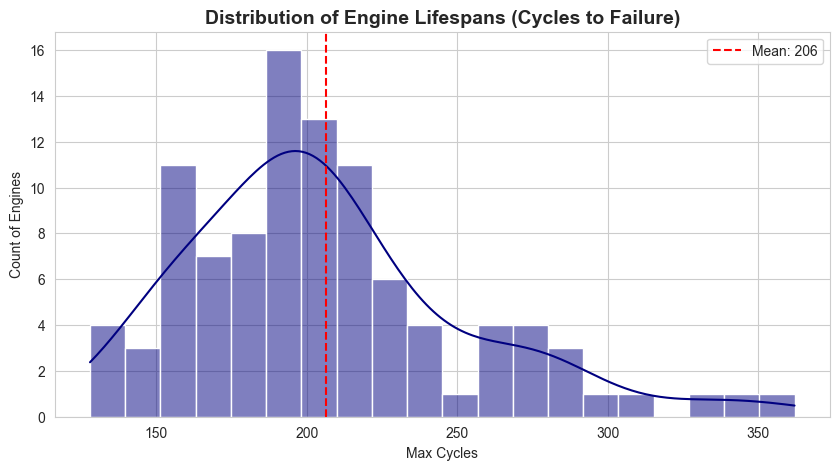

In [2]:
"""
Initial Data Quality Assessment
=================================
Key Questions:
- How many engines are we tracking? (Sample size for model generalization)
- Are there missing values? (Data quality indicator)
- What is the lifespan distribution? (Understanding failure patterns)
"""

# Question 1: How many engines are we tracking?
num_engines = df['unit_nr'].nunique()
print(f"📊 Number of engines: {num_engines}")

# Question 2: Are there missing values?
missing_values = df.isnull().sum().sum()
print(f"🔍 Missing values: {missing_values} (✓ Clean dataset)")

# Question 3: What is the lifespan distribution? (How long do engines live?)
# We group by engine (unit_nr) and find the max cycle time
max_cycles = df.groupby('unit_nr')['time_cycles'].max()

print(f"📈 Lifespan Statistics:")
print(f"   Mean: {max_cycles.mean():.0f} cycles")
print(f"   Std Dev: {max_cycles.std():.0f} cycles")
print(f"   Range: {max_cycles.min():.0f} - {max_cycles.max():.0f} cycles")

plt.figure(figsize=(10,5))
sns.histplot(max_cycles, kde=True, bins=20, color='navy')
plt.title('Distribution of Engine Lifespans (Cycles to Failure)', fontsize=14, fontweight='bold')
plt.xlabel('Max Cycles')
plt.ylabel('Count of Engines')
plt.axvline(max_cycles.mean(), color='red', linestyle='--', label=f'Mean: {max_cycles.mean():.0f}')
plt.legend()
plt.show()

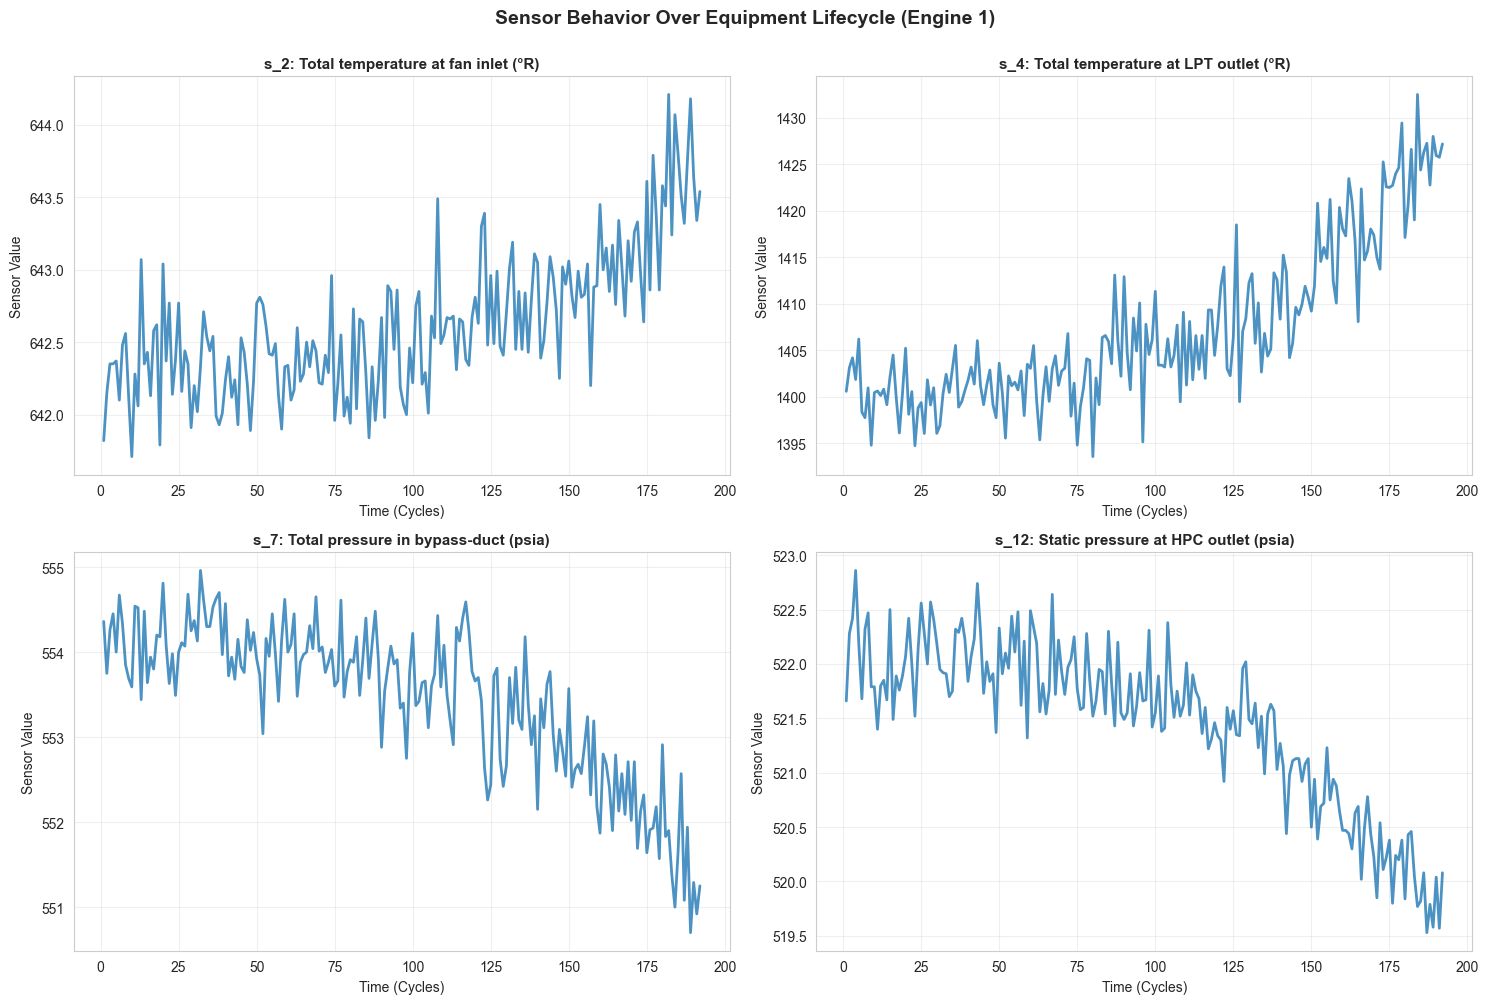

In [3]:
"""
Sensor Behavior Analysis: Time-Series Patterns
================================================
Objective: Understand how different sensors behave as engines degrade over time.

Key Observations to Look For:
- Monotonic trends (increasing/decreasing) → Degradation indicators
- Cyclical patterns → Operational conditions
- Flatlines → Non-informative sensors (should be removed)
- Noise levels → Need for signal smoothing
"""

# Isolate Engine 1 for detailed analysis
engine_1 = df[df['unit_nr'] == 1]

# Plot specific sensors to see different behaviors
# Selected based on domain knowledge: Pressure and Temperature sensors
sensors_to_plot = ['s_2', 's_4', 's_7', 's_12']
sensor_labels = {
    's_2': 'Total temperature at fan inlet (°R)',
    's_4': 'Total temperature at LPT outlet (°R)', 
    's_7': 'Total pressure in bypass-duct (psia)',
    's_12': 'Static pressure at HPC outlet (psia)'
}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, sensor in enumerate(sensors_to_plot):
    axes[i].plot(engine_1['time_cycles'], engine_1[sensor], 
                color='tab:blue', linewidth=2, alpha=0.8)
    axes[i].set_title(f'{sensor}: {sensor_labels[sensor]}', 
                     fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Time (Cycles)')
    axes[i].set_ylabel('Sensor Value')
    axes[i].grid(alpha=0.3)

plt.suptitle('Sensor Behavior Over Equipment Lifecycle (Engine 1)', 
            fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

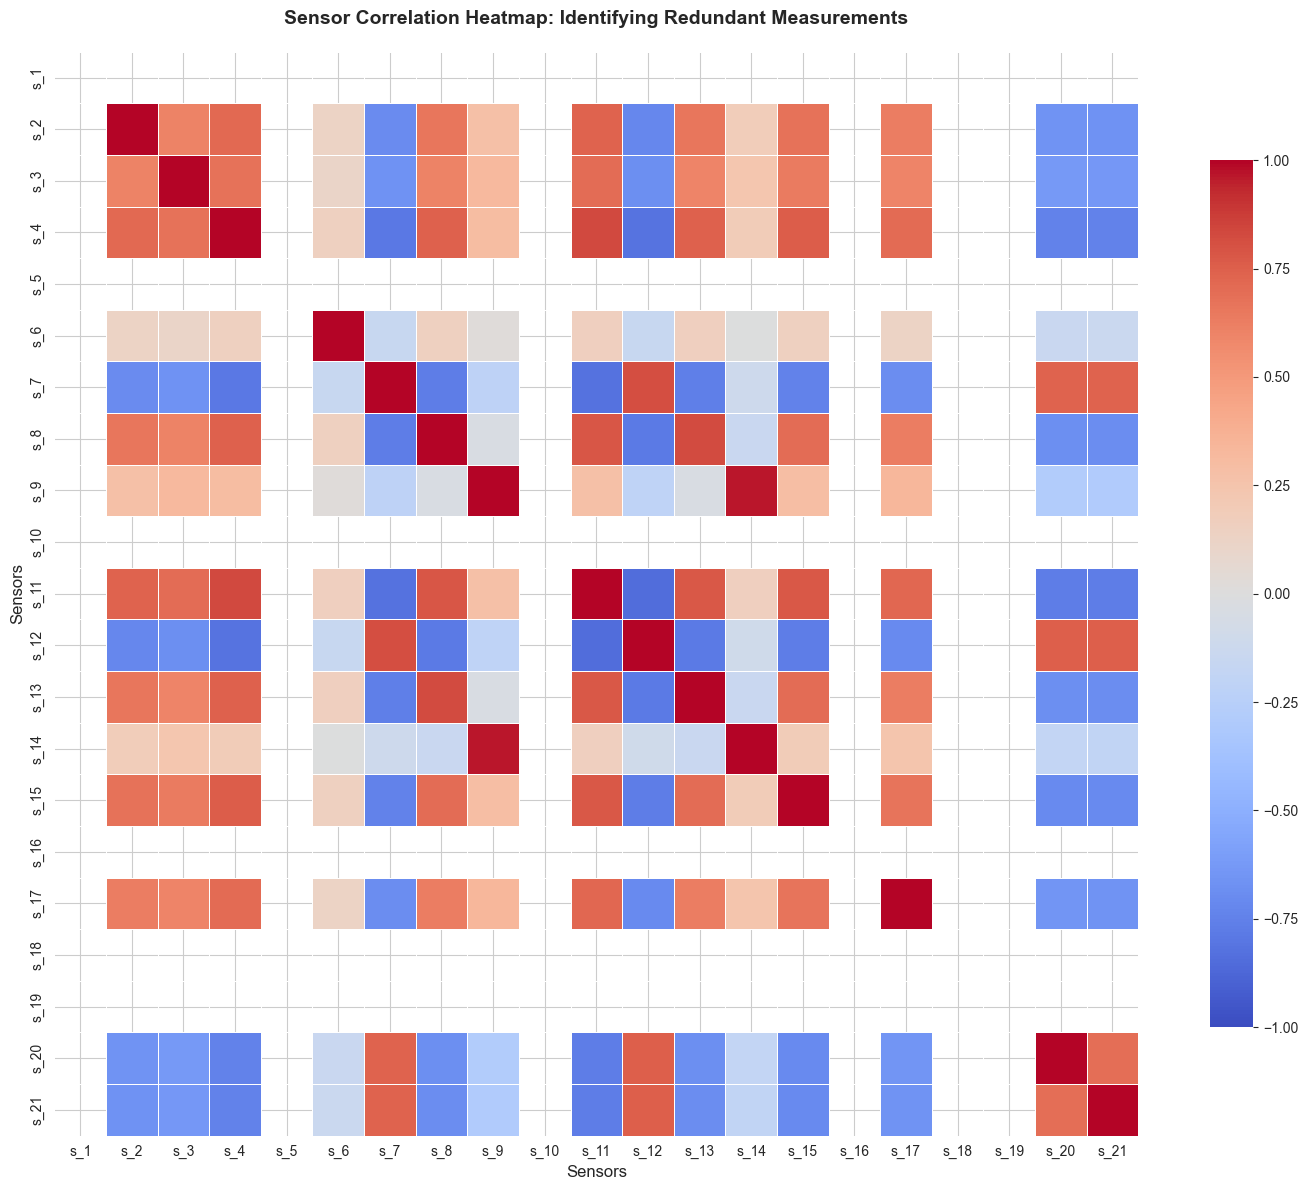


🔗 Highly Correlated Sensor Pairs (|r| > 0.9):
   s_9 ↔ s_14: r = 0.963


In [4]:
"""
Correlation Analysis: Identifying Sensor Relationships
========================================================
Purpose: 
- Detect multicollinearity (redundant sensors measuring same phenomena)
- Understand physical relationships between sensors
- Guide feature selection for modeling

High correlations (|r| > 0.9) suggest:
- Sensors measuring related physical properties
- Potential for dimensionality reduction
- Opportunities to simplify model (fewer features, better interpretability)
"""

# Calculate correlation matrix for all sensors
corr_matrix = df[sensor_names].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', 
           vmin=-1, vmax=1, center=0, square=True,
           linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Sensor Correlation Heatmap: Identifying Redundant Measurements', 
         fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Sensors', fontsize=12)
plt.ylabel('Sensors', fontsize=12)
plt.tight_layout()
plt.show()

# Print highly correlated pairs (potential redundancy)
print("\n🔗 Highly Correlated Sensor Pairs (|r| > 0.9):")
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], 
                            corr_matrix.iloc[i, j]))
            
if high_corr:
    for sensor1, sensor2, corr_val in high_corr[:5]:  # Show top 5
        print(f"   {sensor1} ↔ {sensor2}: r = {corr_val:.3f}")
else:
    print("   No highly correlated pairs found (good for feature independence)")

## 🎯 Key Findings from Exploratory Analysis

**Data Quality:**
- ✅ No missing values detected
- ✅ 100 engines tracked with varying lifespans (128-362 cycles)
- ⚠️ Several sensors show constant values (will be removed in data quality phase)

**Degradation Patterns:**
- 📈 Some sensors exhibit **monotonic trends** over time → Strong degradation indicators
- 🌊 Others show **cyclical/noisy behavior** → Require smoothing for feature extraction
- 📊 High correlation between certain sensor pairs → Opportunity for dimensionality reduction

**Next Steps:**
1. Remove flatline/constant sensors (data quality improvement)
2. Apply rolling window smoothing to denoise signals
3. Engineer trend-based features (slopes, moving averages)
4. Build predictive model using cleaned, engineered features

---